In [0]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch,urllib,zipfile
from torchvision.datasets import MNIST as tmnist
from torchvision import transforms
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
from sklearn.datasets import make_classification
dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Basic Examples

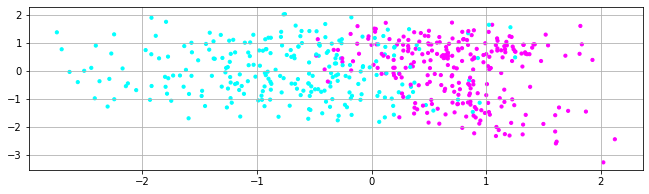

In [3]:
# artificial data
N=500; n=int(.2*N)
X,y=make_classification(n_samples=N,n_features=2,
                        n_redundant=0,n_informative=2)
mu,std=np.mean(X,axis=0),np.std(X,axis=0)
X=(X-mu)/std
X,y=X.astype('float32'),y.astype('int32')
pl.figure(figsize=(11,3)); pl.grid()
pl.scatter(X[:,0],X[:,1],marker='o',
           s=10,c=y,cmap='cool');

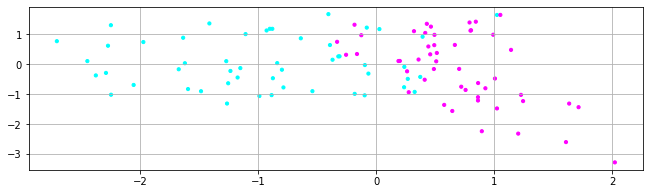

In [4]:
# shuffling & splitting
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
X,y=X[shuffle_ids],y[shuffle_ids]
X_test,X_train=X[:n],X[n:]
y_test,y_train=y[:n],y[n:]
pl.figure(figsize=(11,3)); pl.grid()
pl.scatter(X_test[:,0],X_test[:,1],marker='o',
           s=10,c=y_test,cmap='cool');

In [0]:
class Perceptron():
    def __init__(self,num_features):
        self.num_features=num_features
        self.weights=torch.zeros(num_features,1, 
                                 dtype=torch.float32,device=dev)
        self.bias=torch.zeros(1,dtype=torch.float32,device=dev)
    def forward(self,x):
        values=torch.add(torch.mm(x,self.weights),self.bias)
        a,b=torch.ones(values.size()[0],1),torch.zeros(values.size()[0],1)
        predictions=torch.where(values>0.,a,b).float()
        return predictions        
    def backward(self,x,y):  
        predictions=self.forward(x)
        errors=y-predictions
        return errors        
    def train(self,x,y,epochs):
        for e in range(epochs):            
            for i in range(y.size()[0]):
                errors=self.backward(x[i].view(1,self.num_features),
                                     y[i]).view(-1)
                self.weights+=(errors*x[i]).view(self.num_features,1)
                self.bias+=errors                
    def acc(self,x,y):
        predictions=self.forward(x).view(-1)
        accuracy=torch.sum(predictions==y).float()/y.size()[0]
        return accuracy

In [6]:
model=Perceptron(num_features=2)
tX_train=torch.tensor(X_train,dtype=torch.float32,device=dev)
ty_train=torch.tensor(y_train,dtype=torch.float32,device=dev)
model.train(tX_train,ty_train,epochs=5)
print('Weights: %s'%model.weights)
print('Bias: %s'%model.bias)

Weights: tensor([[1.7455],
        [0.8777]])
Bias: tensor([0.])


In [7]:
# evaluating
tX_test=torch.tensor(X_test,dtype=torch.float32,
                     device=dev)
ty_test=torch.tensor(y_test,dtype=torch.float32,
                     device=dev)
acc_test=model.acc(tX_test,ty_test)
print('Test accuracy: %.2f%%'%(acc_test*100))

Test accuracy: 87.00%


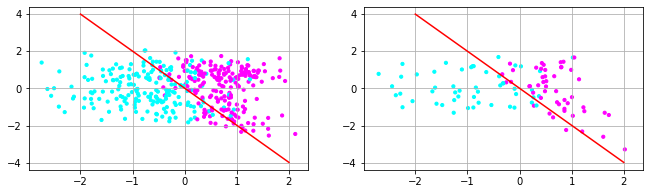

In [8]:
W,b=model.weights,model.bias
x_min=-2; x_max=2
y_min=((-(W[0]*x_min)-b[0])/W[1])
y_max=((-(W[0]*x_max)-b[0])/W[1])
fig,ax=pl.subplots(1,2,sharex=True,figsize=(11,3))
ax[0].plot([x_min,x_max],[y_min,y_max],c='red')
ax[1].plot([x_min,x_max],[y_min,y_max],c='red')
ax[0].scatter(X_train[:,0],X_train[:,1],
              c=y_train,s=10,cmap=pl.cm.cool)
ax[1].scatter(X_test[:,0], X_test[:,1],
              c=y_test,s=10,cmap=pl.cm.cool)
ax[0].grid(); ax[1].grid()

In [0]:
class LogisticRegression():
    def __init__(self,num_features):
        self.num_features=num_features
        self.weights=torch.zeros(num_features,1, 
                                dtype=torch.float32,device=dev)
        self.bias=torch.zeros(1,dtype=torch.float32,device=dev)
    def forward(self,x):
        values=torch.add(torch.mm(x,self.weights),self.bias)
        probs=self._sigmoid(values)
        return probs       
    def backward(self,probs,y):  
        errors=y-probs.view(-1)
        return errors            
    def predict_labels(self,x):
        probs=self.forward(x)
        a=torch.ones(probs.size()[0],1)
        b=torch.zeros(probs.size()[0],1)
        labels=torch.where(probs>=.5,a,b)
        return labels                
    def acc(self,x,y):
        labels=self.predict_labels(x).float()
        accuracy=torch.sum(labels.view(-1)==y).float()/y.size()[0]
        return accuracy    
    def _sigmoid(self,z):
        return 1./(1.+torch.exp(-z))    
    def _logit_cost(self,y,prob):
        tmp1=torch.mm(-y.view(1,-1),torch.log(prob))
        tmp2=torch.mm((1-y).view(1,-1),torch.log(1-prob))
        return tmp1-tmp2
    def train(self,x,y,epochs,learning_rate=.01):
        for e in range(epochs):
            probs=self.forward(x)
            errors=self.backward(probs,y)
            neg_grad=torch.mm(x.transpose(0,1),errors.view(-1,1))
            self.weights+=learning_rate*neg_grad
            self.bias+=learning_rate*torch.sum(errors)
            print('Epoch: %03d'%(e+1),end="")
            print(' | Train accuracy: %.3f'%self.acc(x,y),end="")
            print(' | Cost: %.3f'%self._logit_cost(y,self.forward(x)))

In [10]:
model=LogisticRegression(num_features=2)
model.train(tX_train,ty_train,epochs=10,learning_rate=.02)
print('Weights: %s'%model.weights)
print('Bias: %s'%model.bias)

Epoch: 001 | Train accuracy: 0.890 | Cost: 116.380
Epoch: 002 | Train accuracy: 0.905 | Cost: 111.591
Epoch: 003 | Train accuracy: 0.905 | Cost: 110.401
Epoch: 004 | Train accuracy: 0.905 | Cost: 109.666
Epoch: 005 | Train accuracy: 0.905 | Cost: 109.173
Epoch: 006 | Train accuracy: 0.905 | Cost: 108.832
Epoch: 007 | Train accuracy: 0.905 | Cost: 108.590
Epoch: 008 | Train accuracy: 0.905 | Cost: 108.416
Epoch: 009 | Train accuracy: 0.900 | Cost: 108.288
Epoch: 010 | Train accuracy: 0.900 | Cost: 108.194
Weights: tensor([[3.7606],
        [0.4683]])
Bias: tensor([-0.4295])


In [11]:
# evaluating
acc_test=model.acc(tX_test,ty_test)
print('Test accuracy: %.2f%%'%(acc_test*100))

Test accuracy: 87.00%


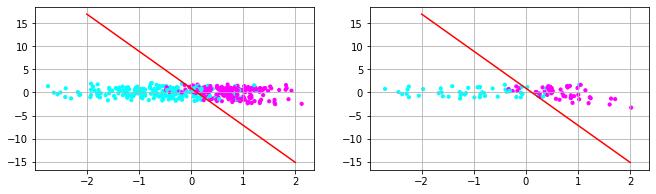

In [12]:
W,b=model.weights,model.bias
x_min=-2; x_max=2
y_min=((-(W[0]*x_min)-b[0])/W[1])
y_max=((-(W[0]*x_max)-b[0])/W[1])
fig,ax=pl.subplots(1,2,sharex=True,figsize=(11,3))
ax[0].plot([x_min,x_max],[y_min,y_max],c='red')
ax[1].plot([x_min,x_max],[y_min,y_max],c='red')
ax[0].scatter(X_train[:,0],X_train[:,1],
              c=y_train,s=10,cmap=pl.cm.cool)
ax[1].scatter(X_test[:,0], X_test[:,1],
              c=y_test,s=10,cmap=pl.cm.cool)
ax[0].grid(); ax[1].grid()

## Softmax Regression

In [14]:
random_seed=23; batch_size=128
train=tmnist(root='data',train=True,download=True,
            transform=transforms.ToTensor())
test=tmnist(root='data',train=False, 
            transform=transforms.ToTensor())
train_loader=tdl(dataset=train,shuffle=True, 
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False, 
                batch_size=batch_size)
for images,labels in train_loader:  
    print('Image dimensions: %s'%str(images.shape))
    print('Label dimensions: %s'%str(labels.shape))
    break

Image dimensions: torch.Size([128, 1, 28, 28])
Label dimensions: torch.Size([128])


In [0]:
learning_rate=.1; epochs=15
num_features=784; num_classes=10
class SoftmaxRegression(torch.nn.Module):
    def __init__(self,num_features,num_classes):
        super(SoftmaxRegression,self).__init__()
        self.linear=torch.nn.Linear(num_features,num_classes)        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()     
    def forward(self,x):
        logits=self.linear(x)
        probs=tnnf.softmax(logits,dim=1)
        return logits,probs
model=SoftmaxRegression(num_features=num_features,
                        num_classes=num_classes)
model.to(dev)
optimizer=torch.optim.SGD(model.parameters(),
                          lr=learning_rate) 

In [0]:
def model_acc(model,data_loader,num_features):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.view(-1,num_features).to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100

In [18]:
for epoch in range(epochs):
    for batch_ids,(features,targets) in enumerate(train_loader):        
        features=features.view(-1,num_features).to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        cost=tnnf.cross_entropy(logits,targets)
        optimizer.zero_grad(); cost.backward()
        optimizer.step()
        if not batch_ids%200:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1,epochs,batch_ids, 
                     len(train)//batch_size,cost))           
    with torch.set_grad_enabled(False):
        print('Epoch: %03d/%03d train accuracy: %.2f%%'%\
              (epoch+1,epochs,model_acc(model,train_loader,num_features)))

Epoch: 001/015 | Batch 000/468 | Cost: 2.3026
Epoch: 001/015 | Batch 200/468 | Cost: 0.4450
Epoch: 001/015 | Batch 400/468 | Cost: 0.3575
Epoch: 001/015 train accuracy: 89.24%
Epoch: 002/015 | Batch 000/468 | Cost: 0.4169
Epoch: 002/015 | Batch 200/468 | Cost: 0.2625
Epoch: 002/015 | Batch 400/468 | Cost: 0.4221
Epoch: 002/015 train accuracy: 90.24%
Epoch: 003/015 | Batch 000/468 | Cost: 0.2734
Epoch: 003/015 | Batch 200/468 | Cost: 0.2882
Epoch: 003/015 | Batch 400/468 | Cost: 0.3680
Epoch: 003/015 train accuracy: 90.69%
Epoch: 004/015 | Batch 000/468 | Cost: 0.2429
Epoch: 004/015 | Batch 200/468 | Cost: 0.3010
Epoch: 004/015 | Batch 400/468 | Cost: 0.3721
Epoch: 004/015 train accuracy: 91.22%
Epoch: 005/015 | Batch 000/468 | Cost: 0.3285
Epoch: 005/015 | Batch 200/468 | Cost: 0.3937
Epoch: 005/015 | Batch 400/468 | Cost: 0.2614
Epoch: 005/015 train accuracy: 91.43%
Epoch: 006/015 | Batch 000/468 | Cost: 0.3227
Epoch: 006/015 | Batch 200/468 | Cost: 0.3390
Epoch: 006/015 | Batch 400/4

In [19]:
print('Test accuracy: %.2f%%'%(model_acc(model,test_loader,num_features)))

Test accuracy: 92.24%


## Applying to Color Images

In [22]:
fpath='https://olgabelitskaya.github.io/'
zf='FlowerColorImages.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)
X=np.array(f[keys[0]],dtype='float32')/255
y=np.array(f[keys[1]],dtype='int32')
N=len(y); n=int(.2*N); batch_size=16
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
X,y=X[shuffle_ids],y[shuffle_ids]
X_test,X_train=X[:n],X[n:]
y_test,y_train=y[:n],y[n:]
X_train.shape,y_train.shape

['images', 'labels']


((168, 128, 128, 3), (168,))

In [23]:
class TData(tds):
    def __init__(self,X,y):   
        self.X=torch.tensor(X,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        train_img,train_lbl=self.X[index],self.y[index]
        return train_img,train_lbl
    def __len__(self):
        return self.y.shape[0]
train=TData(X_train,y_train)
test=TData(X_test,y_test)
train_loader=tdl(dataset=train,batch_size=batch_size,shuffle=True)
test_loader=tdl(dataset=test,batch_size=batch_size,shuffle=False)
for images,labels in train_loader:  
    print('Image dimensions: %s'%str(images.shape))
    print('Label dimensions: %s'%str(labels.shape))
    break

Image dimensions: torch.Size([16, 128, 128, 3])
Label dimensions: torch.Size([16])


In [0]:
learning_rate=.01; epochs=25
num_features=49152; num_classes=10
torch.manual_seed(random_seed)
model=SoftmaxRegression(num_features=num_features,
                         num_classes=num_classes)
model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [25]:
for epoch in range(epochs):
    for batch_ids,(features,targets) in enumerate(train_loader):        
        features=features.view(-1,num_features).to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        cost=tnnf.cross_entropy(logits,targets.long())
        optimizer.zero_grad(); cost.backward()
        optimizer.step()
        if not batch_ids%10:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1,epochs,batch_ids, 
                     len(train)//batch_size,cost))           
    with torch.set_grad_enabled(False):
        print('Epoch: %03d/%03d train accuracy: %.2f%%'%\
              (epoch+1,epochs,model_acc(model,train_loader,num_features)))

Epoch: 001/025 | Batch 000/010 | Cost: 2.3026
Epoch: 001/025 | Batch 010/010 | Cost: 244.7413
Epoch: 001/025 train accuracy: 10.12%
Epoch: 002/025 | Batch 000/010 | Cost: 217.9884
Epoch: 002/025 | Batch 010/010 | Cost: 112.1601
Epoch: 002/025 train accuracy: 42.86%
Epoch: 003/025 | Batch 000/010 | Cost: 93.7377
Epoch: 003/025 | Batch 010/010 | Cost: 52.2275
Epoch: 003/025 train accuracy: 40.48%
Epoch: 004/025 | Batch 000/010 | Cost: 61.8230
Epoch: 004/025 | Batch 010/010 | Cost: 24.6813
Epoch: 004/025 train accuracy: 63.10%
Epoch: 005/025 | Batch 000/010 | Cost: 33.0625
Epoch: 005/025 | Batch 010/010 | Cost: 48.2477
Epoch: 005/025 train accuracy: 63.10%
Epoch: 006/025 | Batch 000/010 | Cost: 38.7063
Epoch: 006/025 | Batch 010/010 | Cost: 14.5738
Epoch: 006/025 train accuracy: 74.40%
Epoch: 007/025 | Batch 000/010 | Cost: 42.1194
Epoch: 007/025 | Batch 010/010 | Cost: 16.9471
Epoch: 007/025 train accuracy: 79.76%
Epoch: 008/025 | Batch 000/010 | Cost: 7.4267
Epoch: 008/025 | Batch 010/0

In [26]:
print('Test accuracy: %.2f%%'%(model_acc(model,test_loader,num_features)))

Test accuracy: 42.86%
